In [1]:
import methods.model as model
import methods.dists as dists
import methods.execution as execution

import os 
import sys
import numpy as np
import time
import json
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd

## Running batch simulations

#### Construct an environment with the required packages
Using miniconda: https://www.anaconda.com/docs/getting-started/miniconda/main
```
# Create the environment
conda env create -f environment.yml

# Activate the environment
conda activate txns
```

#### The batch script is `simulations.py`
```
# Run the batch script
python simulations.py

# The help will show you the basic arguments
python simulations.py --help

usage: simulations.py [-h] [--test] [--output_dir OUTPUT_DIR] [--seed SEED]
Run a batch of transaction simulations.
options:
  -h, --help            show this help message and exit
  --test                Run in test mode (default: False)
  --output_dir OUTPUT_DIR
                        Output directory for results
  --seed SEED           Specify a random seed

```

## Setting up a batch
### Many arguments are specified in the batch simulator `simulate.py`.

In [2]:
# For this notebook, define the output directories here not inline
projdir = os.path.abspath(os.getcwd())
simsdir = os.path.join(projdir, 'output')

# For the tutorial, we will run in test mode
test = True

# It is possible to set a random seed for reproducibility
seed = 42

#### This cell defines constants and default values used throughout the simulation


In [3]:
rng = np.random.default_rng(seed=42) #! this doesn't work completely as expected, do not mind

SIZE_SCALE = 1  # Scale factor for the number of agents
LENGTH_SCALE = 6  # Scale factor for the number of transactions
MEAN_IET = 43706315  # Actually, total time in seconds, not IET. 43706315 seconds =  1 Sarafu time unit (About 1 yr and a half)

N = 25_000 // SIZE_SCALE  # Number of agents
T = int(500_000 * LENGTH_SCALE)  # Total number of transactions. 500_00 is about the number we have in sarafu dataset (a bit more)
D = T / MEAN_IET  # Number of days (currently unused)
saved = 500_000  # Number of iterations to save

#### Enable Test Mode for Quick Debugging

If the test flag is active, smaller values are used for faster iteration and debugging.


In [4]:
if test:
    N = 500
    T = 50
    saved = 20

print(f"Iteration : {T:_}")
print(f"Save : {saved:_}")

Iteration : 50
Save : 20


### Define All Distributions for Agent Behavior

In this step, we define all key statistical behaviors for agents using named distributions:

- **Spending Rate**: Probability of spending per agent.
- **Initial Balance**: Starting funds for each agent.
- **Activity**: Likelihood to initiate a transaction.
- **Attractivity**: Likelihood to be selected as a recipient.
- **Copula**: Joint distribution capturing dependency between activity and attractivity.

Each is represented by:
- A name
- Parameters
- A lambda function for value generation


In [5]:
# Spending rate distribution
spending_rate_list = [
    ("uniform", [0, 1], lambda N: rng.uniform(1e-16, 1, N)),
    # ("beta", [0.4, 0.6], lambda N: rng.beta(0.4, 0.6, N)),
]

# Initial balances
initial_bal_list = [
    ("constant", [1000], lambda N: 1000 * np.ones(N)),
    # ("uniform", [0, 2000], lambda N: rng.uniform(1e-16, 2000, N)),
]

# Activity distribution
activity_distributions = [
    ("powlaw", [1.85, 1, 1838], lambda unif: dists.powlaw_ppf(1.85, 1, 1838)(unif)),
]

# Attractivity distribution
attractivity_distributions = [
    ("powlaw", [1.87, 1, 2118], lambda unif: dists.powlaw_ppf(1.87, 1, 2118)(unif)),
]

# Copula for joint distribution of activity and attractivity
copulas = [
    ('joe', 3.15, False),
    # ('joe', 1, False),
]


### Define the remaining parameters

We use lists, always. When we use the same value over all the simulations we use a single valued list

In [6]:
betabinomial_s = [1, 2, 3, 5, None]  # Scale parameters for beta-binomial behavior
burstiness = [0.25, 1]             # Temporal clustering of activity
decimals = [3]                     # Decimal precision for numerical values


### Define the Simulation Parameter Grid

Here, we organize all simulation parameters into a dictionary. Each key maps to a list of values that will be used to create all combinations of parameter settings.

This parameter grid drives the batch simulations by specifying:
- Agent and environment properties
- Behavioral distribution types
- Simulation scales and precision


In [7]:
parameter_dict = {
    "s": betabinomial_s,  # List of scaling values (always use list)
    "spending_rate": spending_rate_list,
    "initial_balance": initial_bal_list,
    "decimals": decimals, # Decimal precision for balances
    "copula": copulas,
    "activity_distribution": activity_distributions,
    "attractivity_distribution": attractivity_distributions,
    "N": [N],  # Number of agents
    "T": [T],  # Total time steps
    "D": [D],  # Derived value (optional use)
    "SIZE_SCALE": [SIZE_SCALE],
    "LENGTH_SCALE": [LENGTH_SCALE],
    "MEAN_IET": [MEAN_IET],
    "burstiness": burstiness,  # Activity burst levels
}


### Create Output Directory

This step sets the output directory based on whether test mode is enabled. It ensures the directory exists before running simulations.

If not in test mode, the script pauses for confirmation to avoid accidental writes.


In [8]:
continue_running = 'y'  # Automatically proceed (no prompt)

if continue_running == 'n':
    print('Please create the output directory')
    exit()

# Choose output path based on test mode
output_dir = (
    os.path.join(simsdir, 'test') if test else os.path.join(simsdir)
)

if not test:
    print(output_dir)
    input('Continue?')  # Pause for confirmation in full run mode

# Ensure the directory exists
os.makedirs(output_dir, exist_ok=True)


### Generate Parameter Grid and Run Simulations

In this final step:

1. We generate all combinations of the parameter settings using `create_parameter_grid`.
2. We pass this grid to the batch runner along with:
   - The number of transactions to save.
   - The output directory path.

This will launch the full set of simulations using the specified agent behaviors and environment settings.


Batch Simulations:  20%|██        | 2/10 [00:00<00:00, 16.15it/s]

Completed simulation: {'s': 1, 'spending_rate': ('uniform', [0, 1], <function <lambda> at 0x14f0e7a60>), 'initial_balance': ('constant', [1000], <function <lambda> at 0x14f0e7ba0>), 'decimals': 3, 'copula': ('joe', 3.15, False), 'activity_distribution': ('powlaw', [1.85, 1, 1838], <function <lambda> at 0x14f0e7d80>), 'attractivity_distribution': ('powlaw', [1.87, 1, 2118], <function <lambda> at 0x14f0e7e20>), 'N': 500, 'T': 50, 'D': 0.0686399665586083, 'SIZE_SCALE': 1, 'LENGTH_SCALE': 6, 'MEAN_IET': 43706315, 'burstiness': 0.25, 'seed': np.int64(383329927)}
Execution time: 0.02 seconds
End of 0: 212.66 MB (Resident Set Size)
Memory cleared.
Completed simulation: {'s': 1, 'spending_rate': ('uniform', [0, 1], <function <lambda> at 0x14f0e7a60>), 'initial_balance': ('constant', [1000], <function <lambda> at 0x14f0e7ba0>), 'decimals': 3, 'copula': ('joe', 3.15, False), 'activity_distribution': ('powlaw', [1.85, 1, 1838], <function <lambda> at 0x14f0e7d80>), 'attractivity_distribution': ('p

Batch Simulations:  40%|████      | 4/10 [00:00<00:00, 17.90it/s]

Completed simulation: {'s': 2, 'spending_rate': ('uniform', [0, 1], <function <lambda> at 0x14f0e7a60>), 'initial_balance': ('constant', [1000], <function <lambda> at 0x14f0e7ba0>), 'decimals': 3, 'copula': ('joe', 3.15, False), 'activity_distribution': ('powlaw', [1.85, 1, 1838], <function <lambda> at 0x14f0e7d80>), 'attractivity_distribution': ('powlaw', [1.87, 1, 2118], <function <lambda> at 0x14f0e7e20>), 'N': 500, 'T': 50, 'D': 0.0686399665586083, 'SIZE_SCALE': 1, 'LENGTH_SCALE': 6, 'MEAN_IET': 43706315, 'burstiness': 0.25, 'seed': np.int64(2811363264)}
Execution time: 0.02 seconds
End of 2: 215.58 MB (Resident Set Size)
Memory cleared.
Completed simulation: {'s': 2, 'spending_rate': ('uniform', [0, 1], <function <lambda> at 0x14f0e7a60>), 'initial_balance': ('constant', [1000], <function <lambda> at 0x14f0e7ba0>), 'decimals': 3, 'copula': ('joe', 3.15, False), 'activity_distribution': ('powlaw', [1.85, 1, 1838], <function <lambda> at 0x14f0e7d80>), 'attractivity_distribution': ('

Batch Simulations:  60%|██████    | 6/10 [00:00<00:00, 18.32it/s]

Completed simulation: {'s': 3, 'spending_rate': ('uniform', [0, 1], <function <lambda> at 0x14f0e7a60>), 'initial_balance': ('constant', [1000], <function <lambda> at 0x14f0e7ba0>), 'decimals': 3, 'copula': ('joe', 3.15, False), 'activity_distribution': ('powlaw', [1.85, 1, 1838], <function <lambda> at 0x14f0e7d80>), 'attractivity_distribution': ('powlaw', [1.87, 1, 2118], <function <lambda> at 0x14f0e7e20>), 'N': 500, 'T': 50, 'D': 0.0686399665586083, 'SIZE_SCALE': 1, 'LENGTH_SCALE': 6, 'MEAN_IET': 43706315, 'burstiness': 1, 'seed': np.int64(3687649985)}
Execution time: 0.02 seconds
End of 5: 218.03 MB (Resident Set Size)
Memory cleared.
Completed simulation: {'s': 5, 'spending_rate': ('uniform', [0, 1], <function <lambda> at 0x14f0e7a60>), 'initial_balance': ('constant', [1000], <function <lambda> at 0x14f0e7ba0>), 'decimals': 3, 'copula': ('joe', 3.15, False), 'activity_distribution': ('powlaw', [1.85, 1, 1838], <function <lambda> at 0x14f0e7d80>), 'attractivity_distribution': ('pow

Batch Simulations: 100%|██████████| 10/10 [00:00<00:00, 19.39it/s]

Memory cleared.
Completed simulation: {'s': 5, 'spending_rate': ('uniform', [0, 1], <function <lambda> at 0x14f0e7a60>), 'initial_balance': ('constant', [1000], <function <lambda> at 0x14f0e7ba0>), 'decimals': 3, 'copula': ('joe', 3.15, False), 'activity_distribution': ('powlaw', [1.85, 1, 1838], <function <lambda> at 0x14f0e7d80>), 'attractivity_distribution': ('powlaw', [1.87, 1, 2118], <function <lambda> at 0x14f0e7e20>), 'N': 500, 'T': 50, 'D': 0.0686399665586083, 'SIZE_SCALE': 1, 'LENGTH_SCALE': 6, 'MEAN_IET': 43706315, 'burstiness': 1, 'seed': np.int64(2995172877)}
Execution time: 0.02 seconds
End of 7: 218.36 MB (Resident Set Size)
Memory cleared.
Completed simulation: {'s': None, 'spending_rate': ('uniform', [0, 1], <function <lambda> at 0x14f0e7a60>), 'initial_balance': ('constant', [1000], <function <lambda> at 0x14f0e7ba0>), 'decimals': 3, 'copula': ('joe', 3.15, False), 'activity_distribution': ('powlaw', [1.85, 1, 1838], <function <lambda> at 0x14f0e7d80>), 'attractivity_d

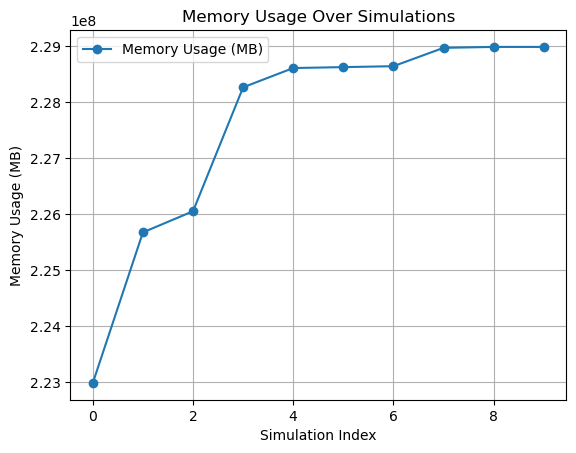

All simulations completed.
Total execution time: 0.60 seconds


<Figure size 640x480 with 0 Axes>

In [9]:
# Create all combinations of parameters
# If a seed is provided, it will be used to generate seeds for each simulation
parameter_grid = execution.create_parameter_grid(parameter_dict,seed=seed)

# Run batch simulations using the generated grid
execution.batch_runner(parameter_grid, output_dir, saved=saved)


# 1.a Inside the `batch_runner()`

In [10]:
# Start the timer for the entire loop
loop_start = time.time()

# Initialize empty list to track memory usage
memory = []

# Define file path for metadata summary
metadata_file = os.path.join(output_dir, "metadata_summary.json")

# Initialize empty list to track metadata summary
metadata_summary = []

## The main loop

In [11]:
# Iterate over each set of parameters
for idx, params in enumerate(tqdm(parameter_grid, desc="Batch Simulations")):
    try:
        # If the number of transactions to save was not specified,
        # use the value from the current parameter set
        if saved is None:
            saved = params['T']

        # Generate unique identifier for simulation
        simulation_id = f'{idx}'
        time_id = f'{int(time.time())}'

        # Run the simulation
        transactions_df, metadata, execution_time, nodes_df = execution.run_simulation(params, saved=saved)

        # Add simulation ID to metadata
        metadata["simulation_id"] = simulation_id

        # Save transactions
        transaction_file = os.path.join(output_dir, f"{simulation_id}.parquet")
        transactions_df.to_parquet(transaction_file, index=False)

        nodes_file = os.path.join(output_dir, f'nodes_{simulation_id}.csv')
        nodes_df.to_csv(nodes_file, index=False)

        # Save metadata for this simulation
        metadata_file_path = os.path.join(output_dir, f"{simulation_id}_metadata.json")
        with open(metadata_file_path, 'w') as f:
            json.dump(execution.convert_metadata_to_serializable(metadata), f, indent=4)

        # Track metadata summary
        metadata_summary.append({
            "simulation_id": simulation_id,
            "transaction_file": transaction_file,
            "metadata_file": metadata_file_path,
            "time id": time_id,
            "execution_time": execution_time,
        })

        print(f"Completed simulation: {params}")
        print(f"Execution time: {execution_time:.2f} seconds")
        memory.append(execution.print_memory_usage(f"End of {simulation_id}"))

        # Clear memory after each loop
        execution.clear_memory()

    except Exception as e:
        print(f"Error in simulation {idx}: {e}")
        continue

Batch Simulations:  20%|██        | 2/10 [00:00<00:00, 18.06it/s]

Completed simulation: {'s': 1, 'spending_rate': ('uniform', [0, 1], <function <lambda> at 0x14f0e7a60>), 'initial_balance': ('constant', [1000], <function <lambda> at 0x14f0e7ba0>), 'decimals': 3, 'copula': ('joe', 3.15, False), 'activity_distribution': ('powlaw', [1.85, 1, 1838], <function <lambda> at 0x14f0e7d80>), 'attractivity_distribution': ('powlaw', [1.87, 1, 2118], <function <lambda> at 0x14f0e7e20>), 'N': 500, 'T': 50, 'D': 0.0686399665586083, 'SIZE_SCALE': 1, 'LENGTH_SCALE': 6, 'MEAN_IET': 43706315, 'burstiness': 0.25, 'seed': np.int64(383329927)}
Execution time: 0.02 seconds
End of 0: 222.27 MB (Resident Set Size)
Memory cleared.
Completed simulation: {'s': 1, 'spending_rate': ('uniform', [0, 1], <function <lambda> at 0x14f0e7a60>), 'initial_balance': ('constant', [1000], <function <lambda> at 0x14f0e7ba0>), 'decimals': 3, 'copula': ('joe', 3.15, False), 'activity_distribution': ('powlaw', [1.85, 1, 1838], <function <lambda> at 0x14f0e7d80>), 'attractivity_distribution': ('p

Batch Simulations:  40%|████      | 4/10 [00:00<00:00, 18.52it/s]

Memory cleared.
Completed simulation: {'s': 3, 'spending_rate': ('uniform', [0, 1], <function <lambda> at 0x14f0e7a60>), 'initial_balance': ('constant', [1000], <function <lambda> at 0x14f0e7ba0>), 'decimals': 3, 'copula': ('joe', 3.15, False), 'activity_distribution': ('powlaw', [1.85, 1, 1838], <function <lambda> at 0x14f0e7d80>), 'attractivity_distribution': ('powlaw', [1.87, 1, 2118], <function <lambda> at 0x14f0e7e20>), 'N': 500, 'T': 50, 'D': 0.0686399665586083, 'SIZE_SCALE': 1, 'LENGTH_SCALE': 6, 'MEAN_IET': 43706315, 'burstiness': 0.25, 'seed': np.int64(1859786275)}
Execution time: 0.02 seconds
End of 4: 224.36 MB (Resident Set Size)


Batch Simulations:  60%|██████    | 6/10 [00:00<00:00, 18.18it/s]

Memory cleared.
Completed simulation: {'s': 3, 'spending_rate': ('uniform', [0, 1], <function <lambda> at 0x14f0e7a60>), 'initial_balance': ('constant', [1000], <function <lambda> at 0x14f0e7ba0>), 'decimals': 3, 'copula': ('joe', 3.15, False), 'activity_distribution': ('powlaw', [1.85, 1, 1838], <function <lambda> at 0x14f0e7d80>), 'attractivity_distribution': ('powlaw', [1.87, 1, 2118], <function <lambda> at 0x14f0e7e20>), 'N': 500, 'T': 50, 'D': 0.0686399665586083, 'SIZE_SCALE': 1, 'LENGTH_SCALE': 6, 'MEAN_IET': 43706315, 'burstiness': 1, 'seed': np.int64(3687649985)}
Execution time: 0.02 seconds
End of 5: 224.41 MB (Resident Set Size)
Memory cleared.
Completed simulation: {'s': 5, 'spending_rate': ('uniform', [0, 1], <function <lambda> at 0x14f0e7a60>), 'initial_balance': ('constant', [1000], <function <lambda> at 0x14f0e7ba0>), 'decimals': 3, 'copula': ('joe', 3.15, False), 'activity_distribution': ('powlaw', [1.85, 1, 1838], <function <lambda> at 0x14f0e7d80>), 'attractivity_dist

Batch Simulations:  80%|████████  | 8/10 [00:00<00:00, 18.44it/s]

Memory cleared.
Completed simulation: {'s': None, 'spending_rate': ('uniform', [0, 1], <function <lambda> at 0x14f0e7a60>), 'initial_balance': ('constant', [1000], <function <lambda> at 0x14f0e7ba0>), 'decimals': 3, 'copula': ('joe', 3.15, False), 'activity_distribution': ('powlaw', [1.85, 1, 1838], <function <lambda> at 0x14f0e7d80>), 'attractivity_distribution': ('powlaw', [1.87, 1, 2118], <function <lambda> at 0x14f0e7e20>), 'N': 500, 'T': 50, 'D': 0.0686399665586083, 'SIZE_SCALE': 1, 'LENGTH_SCALE': 6, 'MEAN_IET': 43706315, 'burstiness': 0.25, 'seed': np.int64(865305066)}
Execution time: 0.01 seconds
End of 8: 224.42 MB (Resident Set Size)
Memory cleared.


Batch Simulations: 100%|██████████| 10/10 [00:00<00:00, 19.01it/s]

Completed simulation: {'s': None, 'spending_rate': ('uniform', [0, 1], <function <lambda> at 0x14f0e7a60>), 'initial_balance': ('constant', [1000], <function <lambda> at 0x14f0e7ba0>), 'decimals': 3, 'copula': ('joe', 3.15, False), 'activity_distribution': ('powlaw', [1.85, 1, 1838], <function <lambda> at 0x14f0e7d80>), 'attractivity_distribution': ('powlaw', [1.87, 1, 2118], <function <lambda> at 0x14f0e7e20>), 'N': 500, 'T': 50, 'D': 0.0686399665586083, 'SIZE_SCALE': 1, 'LENGTH_SCALE': 6, 'MEAN_IET': 43706315, 'burstiness': 1, 'seed': np.int64(404488628)}
Execution time: 0.01 seconds
End of 9: 224.42 MB (Resident Set Size)
Memory cleared.


Last steps: 
- save metadata
- display memory usage and execution time

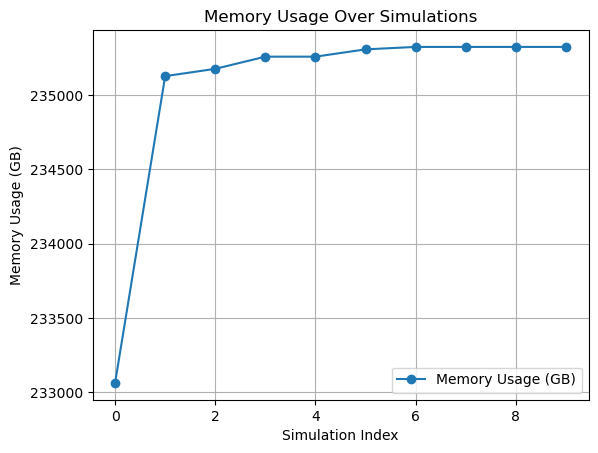

All simulations completed.
Total execution time: 0.59 seconds


<Figure size 640x480 with 0 Axes>

In [12]:
# Save metadata summary
with open(metadata_file, 'w') as f:
    json.dump(metadata_summary, f, indent=4)

# Plot memory usage
plt.figure()
plt.plot(np.array(memory)/(10**3), marker='o', label='Memory Usage (GB)')
plt.xlabel('Simulation Index')
plt.ylabel('Memory Usage (GB)')
plt.title('Memory Usage Over Simulations')
plt.legend()
plt.grid()
plt.show()
plt.savefig(os.path.join(output_dir, "memory_usage_plot.png"))

print("All simulations completed.")
print(f"Total execution time: {time.time() - loop_start:.2f} seconds")

# 2. A single simulation

### Now let's look at how a single run works



In [13]:
#first start the chronometer
start_time = time.time()

## Extracting Simulation Parameters

We load all the basic scalar values needed for the simulation from the `params` dictionary.
These include number of nodes, time steps, decimal precision, and other core settings that define how the simulation behaves.


The `params` dictionary is expected to contain the following keys and value types:

```
params = {
    'seed': int,  # Random seed for reproducibility
    's': int,  # A control parameter for transaction behavior (e.g., entropy or randomness)
    
    'spending_rate': (
        str,             # Type name of the distribution (e.g., 'uniform')
        list[float],     # Parameters for the distribution
        Callable[[int], np.ndarray]  # Function that generates N values
    ),

    'initial_balance': (
        str,             # Type name of the distribution (e.g., 'constant')
        list[float],     # Parameters for the distribution
        Callable[[int], np.ndarray]  # Function that generates N values
    ),

    'decimals': int,  # Number of decimal places for balances

    'copula': (
        str,     # Copula type (e.g., 'joe', 'gumbel', etc.)
        float,   # Parameter for the copula
        bool     # Whether to reverse the copula dependency
    ),

    'activity_distribution': (
        str,             # Distribution type (e.g., 'powlaw')
        list[float],     # Parameters for the distribution
        Callable[[np.ndarray], np.ndarray]  # Generator function
    ),

    'attractivity_distribution': (
        str,             # Distribution type (e.g., 'powlaw')
        list[float],     # Parameters for the distribution
        Callable[[np.ndarray], np.ndarray]  # Generator function
    ),

    'N': int,  # Number of nodes (agents) in the simulation
    'T': int,  # Number of simulation steps (total transactions)
    'D': float,  # A derived or user-defined metric/parameter for the model

    'SIZE_SCALE': float,    # Scaling factor for transaction size
    'LENGTH_SCALE': float,  # Scaling factor for transaction length/duration
    'MEAN_IET': float,      # Mean inter-event time
    'burstiness': float     # Burstiness parameter (controls temporal irregularity)
}


In [14]:
# Extract scalar parameters from the input dictionary
params = parameter_grid[0] #we are using one from the parameter_grid, we can define it from scratch if we want
seed = params["seed"]
s = params["s"]
decimals = params["decimals"]
N = params["N"]
T = params["T"]
D = params["D"]
SIZE_SCALE = params["SIZE_SCALE"]
LENGTH_SCALE = params["LENGTH_SCALE"]
MEAN_IET = params["MEAN_IET"]
burstiness = params["burstiness"]


### Now we extract metadata (name and parameters) of the distributions, and the actual random number generators

In [15]:
# Extract distributions and generators
sprate_type, sprate_params, sprate_generator = params["spending_rate"]
inbal_type, inbal_params, inbal_generator = params["initial_balance"]
copula_type, copula_param, reversed_copula = params["copula"]
activity_type, activity_params, activity_generator = params["activity_distribution"]
attractivity_type, attractivity_params, attractivity_generator = params["attractivity_distribution"]


Generate the actual "Activity" and "Attractiveness" parameters, the expected number of transaction in the given time span "MEAN_IET". As well we generate the initial balances and spending rate parameters.

In [16]:
# Generate activity and attractivity vectors
vect_act, vect_att = execution.generate_activity_attractivity(
    N=N,
    copula_type=copula_type,
    copula_param=copula_param,
    reversed_copula=reversed_copula,
    activity_generator=activity_generator,
    attractivity_generator=attractivity_generator
)


# Generate spending rates and initial balances
spending_rate = sprate_generator(N)
initial_bal = inbal_generator(N)

Now we create the nodes, the transition matrix, we assign the parameters etc

In [17]:
# Initialize the model
nodes = model.create_nodes(
    N, activity=vect_act, attractivity=vect_att,
    spending=spending_rate, mean_iet=MEAN_IET, burstiness=burstiness
)
transitions = model.initialize_transition_matrix(nodes)
activations = model.initialize_activations(nodes)
balances = model.initialize_balances(nodes, balances=initial_bal, decimals=decimals)

The main loop and some saving steps

In [18]:
# Prepare to write transactions
header = ["timestamp", "source", "target", "amount", "source_bal", "target_bal"]

#todo: move saved to params
if saved is None:
    saved = params['T']
transactions_list = [None] * saved
burn_in_period = T - saved

# Run the model
for i in range(T):
    transaction = model.transact(nodes, activations, transitions, balances, method='random_share', s=s)
    if i >= burn_in_period:
        transactions_list[i-burn_in_period] = [transaction[term] for term in header]

# Convert transactions to DataFrame
transactions_df = pd.DataFrame(transactions_list, columns=header)
nodes_df = pd.DataFrame.from_dict(nodes, orient='index').reset_index()

# Compile metadata
metadata = {
    'sprate_type': sprate_type,
    'sprate_params': sprate_params,
    'inbal_type': inbal_type,
    'inbal_params': inbal_params,
    'activity_type': activity_type,
    'activity_params': activity_params,
    'attractivity_type': attractivity_type,
    'attractivity_params': attractivity_params,
    'N': N,
    'T': T,
    'D': D,
    's': s,
    'decimals': decimals,
    'SIZE_SCALE': SIZE_SCALE,
    'LENGTH_SCALE': LENGTH_SCALE,
    'MEAN_IET': MEAN_IET,
    'burstiness': burstiness,
    'copula_type': copula_type,
    'copula_param': copula_param
}

execution_time = time.time() - start_time
# return transactions_df, metadata, execution_time, nodes_df 